In [2]:
%matplotlib inline
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [3]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import numpy as np
np.random.seed(0)
import torch.utils.data as data_utils #maybe do this to clean up


In [6]:
model_name = "vgg"
num_classes = 10 # classes in mnist
batch_size_train = 16
batch_size_test = 16
num_epochs = 200

learning_rate = 0.001
momentum = 0.9
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)
device = torch.device("cuda")

# Download Dataset

In [7]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

indices = torch.arange(1000)

# MNIST Train Dataset
dataset_train  = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=preprocessing)
random_train_targets = np.random.randint(10, size = dataset_train.targets.shape )

dataset_train_random = copy.deepcopy(dataset_train)
dataset_train_random.targets = random_train_targets

dataset_train = torch.utils.data.Subset(dataset_train, indices)
dataset_train_random = torch.utils.data.Subset(dataset_train_random, indices)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)
train_loader_random = torch.utils.data.DataLoader(dataset_train_random, batch_size=batch_size_train, shuffle=True)

# MNIST Test Dataset
dataset_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=preprocessing)

dataset_test = torch.utils.data.Subset(dataset_test, indices)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True)


'''
this part of code, modified to work ith test loop as per:
This code is based upon the Pytorch Example:
  https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
Citation:
  Inkawhich, N. (2021). Finetuning Torchvision Models — PyTorch Tutorials 1.2.0 documentation. Pytorch.org. Retrieved 19 April 2021, from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html.

'''

# Create training and validation datasets
image_datasets = {'train': dataset_train, 'val':dataset_test}
image_datasets_random = {'train': dataset_train_random, 'val':dataset_test}

# Create training and validation dataloaders
dataloaders_dict = {'train': train_loader, 'val':test_loader}
dataloaders_dict_random = {'train': train_loader_random, 'val':test_loader}

# Prebuilts for training

In [ ]:
'''
This code is based upon the Pytorch Example:
  https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
Citation:
  Inkawhich, N. (2021). Finetuning Torchvision Models — PyTorch Tutorials 1.2.0 documentation. Pytorch.org. Retrieved 19 April 2021, from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html.

Training loop and imports import function modified for appliocation:
-- needed loop to train instead of finetune
-- needed to adjust model sizes and hyperparameters
-- note data imports also adjusted to fit with this loop
'''


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if epoch_acc > 0.95:
              time_elapsed = time.time() - since
              print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
              print('Best val Acc: {:4f}'.format(best_acc))

              # load best model weights
              model.load_state_dict(best_model_wts)
              return model, val_acc_history

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract =False, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.features[0] = nn.Conv2d(3, 128, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        model_ft.features[3] = nn.Conv2d(128, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        model_ft.features[6] = nn.Conv2d(384, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        model_ft.features[8] = nn.Conv2d(480, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        model_ft.features[10] =  nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        model_ft.classifier[1] = nn.Linear(in_features=9216, out_features=8192, bias=True)
        model_ft.classifier[4] = nn.Linear(in_features=8192, out_features=4096, bias=True)
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 64

    elif model_name == "vgg":
        """ VGG11
        """
        model_ft = models.vgg11(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 64 #224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Training


In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=False)
model_ft = model_ft.to(device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/199
----------
train Loss: 2.2919 Acc: 0.1420
val Loss: 2.2603 Acc: 0.2337

Epoch 1/199
----------
train Loss: 2.2063 Acc: 0.2350
val Loss: 1.9804 Acc: 0.2994

Epoch 2/199
----------
train Loss: 1.6879 Acc: 0.4300
val Loss: 1.0888 Acc: 0.6206

Epoch 3/199
----------
train Loss: 0.8867 Acc: 0.7030
val Loss: 0.7802 Acc: 0.7248

Epoch 4/199
----------
train Loss: 0.5702 Acc: 0.8240
val Loss: 0.4745 Acc: 0.8362

Epoch 5/199
----------
train Loss: 0.3948 Acc: 0.8760
val Loss: 0.2802 Acc: 0.9097

Epoch 6/199
----------
train Loss: 0.2673 Acc: 0.9180
val Loss: 0.2343 Acc: 0.9220

Epoch 7/199
----------
train Loss: 0.1762 Acc: 0.9460
val Loss: 0.1802 Acc: 0.9401

Epoch 8/199
----------
train Loss: 0.1818 Acc: 0.9430
val Loss: 0.2099 Acc: 0.9322

Epoch 9/199
----------
train Loss: 0.1166 Acc: 0.9630
Training complete in 2m 1s
Best val Acc: 0.940100


In [ ]:
model_ft_random, input_size_random = initialize_model(model_name, num_classes, use_pretrained=False)
model_ft_random = model_ft_random.to(device)
random_optimizer = optim.SGD(model_ft_random.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft_random, hist_rand = train_model(model_ft_random, dataloaders_dict_random, criterion, random_optimizer, num_epochs=num_epochs)

Epoch 0/199
----------
train Loss: 2.3112 Acc: 0.0980
val Loss: 2.3046 Acc: 0.1010

Epoch 1/199
----------
train Loss: 2.3087 Acc: 0.1040
val Loss: 2.3040 Acc: 0.1010

Epoch 2/199
----------
train Loss: 2.3038 Acc: 0.1150
val Loss: 2.3046 Acc: 0.1010

Epoch 3/199
----------
train Loss: 2.2989 Acc: 0.1230
val Loss: 2.3048 Acc: 0.1010

Epoch 4/199
----------
train Loss: 2.3023 Acc: 0.1180
val Loss: 2.3049 Acc: 0.1010

Epoch 5/199
----------
train Loss: 2.2994 Acc: 0.1200
val Loss: 2.3048 Acc: 0.1010

Epoch 6/199
----------
train Loss: 2.2988 Acc: 0.1220
val Loss: 2.3052 Acc: 0.1010

Epoch 7/199
----------
train Loss: 2.2980 Acc: 0.1220
val Loss: 2.3045 Acc: 0.1010

Epoch 8/199
----------
train Loss: 2.2984 Acc: 0.1220
val Loss: 2.3055 Acc: 0.1010

Epoch 9/199
----------
train Loss: 2.2951 Acc: 0.1240
val Loss: 2.3054 Acc: 0.1010

Epoch 10/199
----------
train Loss: 2.2976 Acc: 0.1220
val Loss: 2.3063 Acc: 0.1010

Epoch 11/199
----------
train Loss: 2.2964 Acc: 0.1300
val Loss: 2.3057 Acc

# Spearman rank correlation code

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model_ft, "/content/drive/MyDrive/Colab Notebooks/Project/model_vgg.pth")
torch.save(model_ft_random, "/content/drive/MyDrive/Colab Notebooks/Project/model_rand_vgg.pth")

In [24]:
model_ft = torch.load("/content/drive/MyDrive/Colab Notebooks/Project/model_vgg.pth")
model_ft_random = torch.load("/content/drive/MyDrive/Colab Notebooks/Project/model_rand_vgg.pth")


In [44]:
def spearman_rank_corr(a, b):
    lin_a = a.reshape(-1)#convert iage to linear array for easier processing
    indices_a = lin_a.argsort()
    rank_a = torch.zeros_like(indices_a)
    rank_a[indices_a] = torch.arange(len(lin_a))

    lin_b = b.reshape(-1)
    indices_b = lin_b.argsort()
    rank_b = torch.zeros_like(indices_b)
    rank_b[indices_b] = torch.arange(len(lin_b))

    N = lin_a.size(0)
    num = torch.sum((rank_a - rank_b).pow(2))
    den = N*(N**2-1.0)#need to write like this for numerics, n^3 somestimes caused issues
    return 1.0 - ((6*num)/den)


# SmoothGrad code

In [26]:
def calcImageGrad(image, model):
  model.eval()
  image.requires_grad_()
  output = model(image)
  class_ind = output.argmax()
  #print(class_ind)
  grad = output[0, class_ind]
  #print(grad)
  grad.backward()
  return torch.max(image.grad.data.abs(), dim=1)[0]

  
def smoothGrad(stdev, n, input, model):
  grad_stdev = float((stdev/100)*(torch.max(input[0])-torch.min(input[0])))
  #print("standard dev: ", grad_stdev)
  total =  torch.from_numpy(np.zeros(input.shape))
  image_tensor = input

  for i in range(n):
    #print_progress(i,n)
    size = input.shape
    input_image = (image_tensor.detach() + np.random.normal(0,grad_stdev, size = size)).float()
    input_image.requires_grad_()
    image_grad = calcImageGrad(input_image, model)
    #print(image_grad.shape)
    #print(total.shape)
    total = total+image_grad
  return (total/n)

In [29]:
data, label = dataset_train[0]
data = data.unsqueeze(0)
print(data.shape)
data = data.to("cpu")

torch.Size([1, 3, 64, 64])


In [30]:
model_ft.eval()
model_ft.to("cpu")
output = model_ft(data)

In [27]:
import torch
import torchvision
from torchvision import models
from torchvision import transforms
from torch import nn
import cv2
import numpy as np
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from PIL import Image
import random

def gradCAM(img, model, guided=False, cnn_layer_idx=None, class_idx=None, transform=None, save_heatmap=None, print_cls=False, print_pred=False):
    '''
    PARAMETERS
      img           : image for which grad-CAM will be plotted
      model         : model for which grad-CAM will be plotted
      cnn_layer_idx : (int) grad-CAM will be plotted with the result of this i-th 
                      convolutional layer of the model
      class_idx     : (int) idx of the class for which grad-CAM will be plotted
                      If None, the default predicted class will be used. 
    '''

    output = img

    cnn_i, sequential_i = 0, 0
    cnn_weights = []
    for module_i, module in enumerate(list(model.modules())[1:]):    
      if isinstance(module, torch.nn.modules.container.Sequential):
        continue
      else:       
        try:
          output = module(output)
          if isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d) :
            output = torch.flatten(output, 1)
        except Exception as e:
          print(module_i, module)
        if isinstance(module, torch.nn.modules.conv.Conv2d):
          cnn_weights.append(output)

    ### Step 1 ###
    # gradient of class c score (BEFORE softmax), wrt CNN feature map activations "layer weights"
    if class_idx is None:
      class_idx = torch.argmax(output, dim=-1).item()
    if print_cls:
      print("class:({})".format(class_idx), imagenet_labels[class_idx])
    #predicted
    cls_idx = torch.argmax(output, dim=-1)  
    if print_pred:
      print("predicted class:({})".format(cls_idx.item()), imagenet_labels[cls_idx.item()])
    grads = torch.autograd.grad(output[0, class_idx], cnn_weights[-1], retain_graph=True)
    grads = grads[0].squeeze(0)  # [n_filtermap, W_lastCNN, H_lastCNN]
    if guided:
      # Target for backprop
      one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
      one_hot_output[0][class_idx] = 1
      grads_guided = torch.autograd.grad(one_hot_output, img, retain_graph=True)
      grads_guided = grads_guided[0].squeeze(0)
      # Backward pass
      #output.backward(gradient=one_hot_output)
      # Convert Pytorch variable to numpy array
      # [0] to get rid of the first channel (1,3,224,224)
      #gradients_as_arr = self.gradients.data.numpy()[0]
      grads_guided = torch.clamp(grads_guided, min=0.).detach().numpy()

    ### Step 2 ###
    grads_avgpooled = torch.mean(grads, axis=(1,2))  # [n_filtermap] 
    grads_avgpooled = grads_avgpooled.expand_as(cnn_weights[-1].squeeze(0).permute(1,2,0))
    grads_avgpooled = grads_avgpooled.permute(2,0,1)

    ### Step 3 : ReLU of Linear Combination ###
    
    map = nn.ReLU()(grads_avgpooled*cnn_weights[-1].squeeze(0))   # layer_weights shape
    map = torch.sum(map, dim=0)  # [W_lastCNN, H_lastCNN]
    map_interpolated = np.array(cv2.resize(map.detach().numpy(), dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC))

    if guided:
      guided_map = map_interpolated*grads_guided
      plt.imshow(guided_map.transpose(1,2,0))
      plt.show()

    ### Step 4 ###
    map_interpolated = cv2.resize(map.detach().numpy(), dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC)
    # make color heatmap
    heatmap = cv2.normalize(map_interpolated, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay heatmap on top of the image
    fin = heatmap

    return class_idx, fin[:,:,::-1]

7


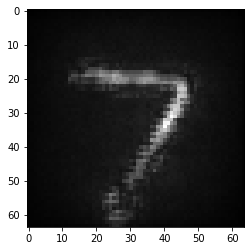

In [22]:
i=0
model_ft.eval()
model_ft = model_ft.to("cpu")
for data, label in dataset_test:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency = smoothGrad(10, 50, data, model_ft)
  plt.imshow(saliency.squeeze(0)[0], cmap=plt.cm.gray)
  print(label)
  break
  
  

7


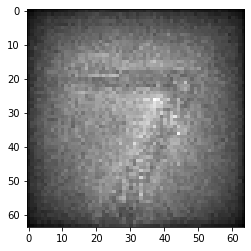

In [32]:
model_ft_random.eval()
model_ft_random = model_ft_random.to("cpu")
for data, label in dataset_test:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency = smoothGrad(10, 50, data, model_ft_random)
  plt.imshow(saliency.squeeze(0)[0], cmap=plt.cm.gray)
  print(label)
  break
  

In [ ]:
spearman_smoothgrad = np.array([])
i=0
for data, label in dataset_test:
  i+=1
  if i == 100:
    break
  print(i,"/1000")
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency_true = smoothGrad(20, 20, data, model_ft)
  saliency_random = smoothGrad(20, 20, data, model_ft_random)
  spearman_smoothgrad = np.append(spearman_smoothgrad,spearman_rank_corr(saliency_true.squeeze(0)[0],  saliency_random.squeeze(0)[0]))



1 /1000
2 /1000
3 /1000
4 /1000
5 /1000
6 /1000
7 /1000
8 /1000
9 /1000
10 /1000
11 /1000
12 /1000
13 /1000
14 /1000
15 /1000
16 /1000
17 /1000
18 /1000
19 /1000
20 /1000
21 /1000
22 /1000
23 /1000
24 /1000
25 /1000
26 /1000
27 /1000
28 /1000
29 /1000
30 /1000
31 /1000
32 /1000
33 /1000
34 /1000
35 /1000
36 /1000
37 /1000
38 /1000
39 /1000
40 /1000
41 /1000
42 /1000
43 /1000
44 /1000
45 /1000
46 /1000
47 /1000
48 /1000
49 /1000
50 /1000
51 /1000
52 /1000
53 /1000
54 /1000
55 /1000
56 /1000
57 /1000
58 /1000
59 /1000
60 /1000
61 /1000
62 /1000
63 /1000
64 /1000
65 /1000
66 /1000
67 /1000
68 /1000
69 /1000
70 /1000
71 /1000
72 /1000
73 /1000
74 /1000
75 /1000
76 /1000
77 /1000
78 /1000
79 /1000
80 /1000
81 /1000
82 /1000
83 /1000
84 /1000
85 /1000
86 /1000
87 /1000
88 /1000
89 /1000
90 /1000
91 /1000
92 /1000
93 /1000
94 /1000
95 /1000
96 /1000
97 /1000
98 /1000
99 /1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


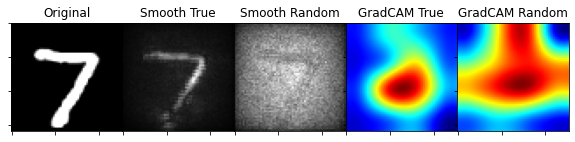

In [33]:
for data, label in dataset_test:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  saliency_smooth_true = smoothGrad(20, 20, data, model_ft)
  _, saliency_gradcam_true = gradCAM(data, model_ft, class_idx=label, cnn_layer_idx=0)
  saliency_smooth_rand = smoothGrad(20, 20, data, model_ft_random)
  _, saliency_gradcam_rand = gradCAM(data, model_ft_random, class_idx=label, cnn_layer_idx=0)
  break
fig, ax = plt.subplots(1,5) 
ax[0].imshow(data.squeeze(0).permute(1,2,0))    
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_aspect("auto")
ax[0].set_title("Original")
ax[1].imshow(saliency_smooth_true.squeeze(0)[0], cmap=plt.cm.gray)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_aspect("auto")
ax[1].set_title("Smooth True")
ax[3].imshow(torch.from_numpy(np.flip(saliency_gradcam_true,axis=0).copy()), cmap=plt.cm.gray)
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].set_aspect("auto")
ax[3].set_title("GradCAM True")
ax[2].imshow(saliency_smooth_rand.squeeze(0)[0], cmap=plt.cm.gray)
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_aspect("auto")
ax[2].set_title("Smooth Random")
ax[4].imshow(torch.from_numpy(np.flip(saliency_gradcam_rand,axis=0).copy()), cmap=plt.cm.gray)
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])
ax[4].set_aspect("auto")
ax[4].set_title("GradCAM Random")

fig.subplots_adjust(wspace=0, hspace = 0)
fig.set_size_inches(10,2)
fig.savefig("/content/drive/MyDrive/Colab Notebooks/Project/output_images/MNIST_vgg11.jpg")

In [ ]:
spearman_smoothgrad

array([0.7993933 , 0.75524271, 0.87460464, 0.75862485, 0.85358685,
       0.83795309, 0.83065557, 0.81405884, 0.72617179, 0.77249652,
       0.76762837, 0.77383101, 0.84524381, 0.79037201, 0.82258308,
       0.75446254, 0.85012203, 0.78165102, 0.7006495 , 0.85954589,
       0.80119491, 0.78569108, 0.84152764, 0.83255064, 0.85281307,
       0.67054778, 0.81404299, 0.8253082 , 0.76606721, 0.85249794,
       0.79938614, 0.84589887, 0.78052855, 0.80438   , 0.72334069,
       0.7614513 , 0.80109078, 0.84318632, 0.83426082, 0.80575395,
       0.88127458, 0.85904181, 0.8253153 , 0.83404911, 0.80252069,
       0.82803166, 0.80511022, 0.82378018, 0.73481274, 0.79511797,
       0.79061639, 0.74491316, 0.79156613, 0.79380625, 0.75475967,
       0.82041329, 0.76462936, 0.85955614, 0.81361562, 0.8805148 ,
       0.72223401, 0.81975532, 0.87229621, 0.80193257, 0.76508862,
       0.87650466, 0.78488439, 0.7954489 , 0.77768898, 0.7502408 ,
       0.76295984, 0.71292758, 0.75159901, 0.77657551, 0.83663

array([0.7993933 , 0.75524271, 0.87460464, 0.75862485, 0.85358685,
       0.83795309, 0.83065557, 0.81405884, 0.72617179, 0.77249652,
       0.76762837, 0.77383101, 0.84524381, 0.79037201, 0.82258308,
       0.75446254, 0.85012203, 0.78165102, 0.7006495 , 0.85954589,
       0.80119491, 0.78569108, 0.84152764, 0.83255064, 0.85281307,
       0.67054778, 0.81404299, 0.8253082 , 0.76606721, 0.85249794,
       0.79938614, 0.84589887, 0.78052855, 0.80438   , 0.72334069,
       0.7614513 , 0.80109078, 0.84318632, 0.83426082, 0.80575395,
       0.88127458, 0.85904181, 0.8253153 , 0.83404911, 0.80252069,
       0.82803166, 0.80511022, 0.82378018, 0.73481274, 0.79511797,
       0.79061639, 0.74491316, 0.79156613, 0.79380625, 0.75475967,
       0.82041329, 0.76462936, 0.85955614, 0.81361562, 0.8805148 ,
       0.72223401, 0.81975532, 0.87229621, 0.80193257, 0.76508862,
       0.87650466, 0.78488439, 0.7954489 , 0.77768898, 0.7502408 ,
       0.76295984, 0.71292758, 0.75159901, 0.77657551, 0.83663374,
       0.83253253, 0.80174041, 0.8623575 , 0.78674895, 0.69210082,
       0.83734965, 0.76046312, 0.744115  , 0.82785535, 0.82802594,
       0.73735285, 0.76667541, 0.789837  , 0.77321357, 0.81760514,
       0.78843731, 0.77622962, 0.84756964, 0.71086097, 0.78042406,
       0.72552383, 0.87137091, 0.7898742 , 0.74541295])

In [45]:
'''
for data, label in dataset_train:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  _, h = gradCAM(data, model_ft, class_idx=label, cnn_layer_idx=0)
  print(h.shape)
  print(h)
  break'''
  
spearman_gradCAM = np.array([])
i=0
for data, label in dataset_test:
  i+=1
  if i == 100:
    break
  print(i,"/1000")
  data = data.unsqueeze(0)
  data = data.to("cpu")
  _, saliency_true = gradCAM(data, model_ft, class_idx=label, cnn_layer_idx=0)
  saliency_true = torch.from_numpy(np.flip(saliency_true,axis=0).copy())
  _, saliency_random = gradCAM(data, model_ft_random, class_idx=label, cnn_layer_idx=0)
  saliency_random = torch.from_numpy(np.flip(saliency_random,axis=0).copy())
  spearman_gradCAM = np.append(spearman_gradCAM,spearman_rank_corr(saliency_true,  saliency_random))



1 /1000
2 /1000
3 /1000
4 /1000
5 /1000
6 /1000
7 /1000
8 /1000
9 /1000
10 /1000
11 /1000
12 /1000
13 /1000
14 /1000
15 /1000
16 /1000
17 /1000
18 /1000
19 /1000
20 /1000
21 /1000
22 /1000
23 /1000
24 /1000
25 /1000
26 /1000
27 /1000
28 /1000
29 /1000
30 /1000
31 /1000
32 /1000
33 /1000
34 /1000
35 /1000
36 /1000
37 /1000
38 /1000
39 /1000
40 /1000
41 /1000
42 /1000
43 /1000
44 /1000
45 /1000
46 /1000
47 /1000
48 /1000
49 /1000
50 /1000
51 /1000
52 /1000
53 /1000
54 /1000
55 /1000
56 /1000
57 /1000
58 /1000
59 /1000
60 /1000
61 /1000
62 /1000
63 /1000
64 /1000
65 /1000
66 /1000
67 /1000
68 /1000
69 /1000
70 /1000
71 /1000
72 /1000
73 /1000
74 /1000
75 /1000
76 /1000
77 /1000
78 /1000
79 /1000
80 /1000
81 /1000
82 /1000
83 /1000
84 /1000
85 /1000
86 /1000
87 /1000
88 /1000
89 /1000
90 /1000
91 /1000
92 /1000
93 /1000
94 /1000
95 /1000
96 /1000
97 /1000
98 /1000
99 /1000


In [46]:
spearman_gradCAM

array([ 0.15929759,  0.15869564, -0.08452594,  0.48854011,  0.30863982,
       -0.1657995 ,  0.31789696,  0.44119453,  0.36869645,  0.13039476,
        0.34683567,  0.26517057,  0.31118077,  0.49120265,  0.18592668,
        0.00977051,  0.1436851 ,  0.47479522,  0.58888668,  0.24992788,
        0.10717249,  0.19615281,  0.11337513, -0.01352978,  0.47595793,
        0.50458395,  0.21393049,  0.45421314,  0.40990382,  0.53162432,
        0.58025819,  0.43484205,  0.4792617 ,  0.67401433,  0.3421424 ,
        0.19537234,  0.40046108,  0.31887215,  0.24583894,  0.20193166,
        0.08714747,  0.40868747,  0.42125392,  0.262703  ,  0.37268728,
        0.15870595,  0.26220971,  0.19268632,  0.36517036,  0.52123123,
        0.29383969,  0.50023019, -0.11485624,  0.09505421,  0.05283308,
        0.38924754,  0.52238476, -0.15169954,  0.06011057,  0.28152514,
        0.58996713,  0.53434432,  0.33459306,  0.38294929,  0.70634246,
        0.35613054,  0.20328867,  0.37019145,  0.24099642,  0.56

array([ 0.15929759,  0.15869564, -0.08452594,  0.48854011,  0.30863982,
       -0.1657995 ,  0.31789696,  0.44119453,  0.36869645,  0.13039476,
        0.34683567,  0.26517057,  0.31118077,  0.49120265,  0.18592668,
        0.00977051,  0.1436851 ,  0.47479522,  0.58888668,  0.24992788,
        0.10717249,  0.19615281,  0.11337513, -0.01352978,  0.47595793,
        0.50458395,  0.21393049,  0.45421314,  0.40990382,  0.53162432,
        0.58025819,  0.43484205,  0.4792617 ,  0.67401433,  0.3421424 ,
        0.19537234,  0.40046108,  0.31887215,  0.24583894,  0.20193166,
        0.08714747,  0.40868747,  0.42125392,  0.262703  ,  0.37268728,
        0.15870595,  0.26220971,  0.19268632,  0.36517036,  0.52123123,
        0.29383969,  0.50023019, -0.11485624,  0.09505421,  0.05283308,
        0.38924754,  0.52238476, -0.15169954,  0.06011057,  0.28152514,
        0.58996713,  0.53434432,  0.33459306,  0.38294929,  0.70634246,
        0.35613054,  0.20328867,  0.37019145,  0.24099642,  0.56830359,
        0.40735406,  0.42836237,  0.41692537,  0.30675668,  0.32461804,
        0.25744981,  0.56669974, -0.02838469,  0.50214911,  0.50577408,
        0.35152406,  0.45568478,  0.44867849,  0.50927794, -0.06110525,
        0.3196798 ,  0.35703611,  0.24368787,  0.12204939, -0.04335916,
        0.61660099,  0.29008472,  0.38709253,  0.55839097,  0.54492545,
        0.35512531,  0.51875913,  0.56803715,  0.47819638])

#Next steps
finish with the other model

potential issues


1.   upscaling images ->as seen in the saliency maps
2.   use of aleznet/ vggc for deep models _. not tailored construction on the networks




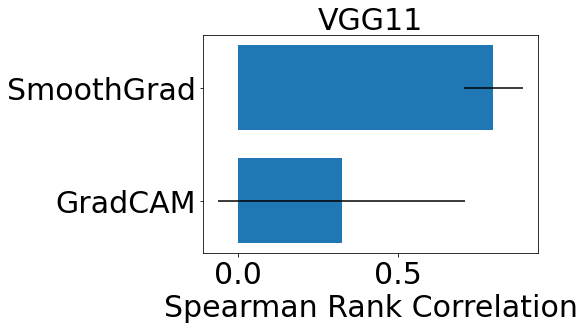

In [ ]:
spearman_smoothgrad = np.array([0.7993933 , 0.75524271, 0.87460464, 0.75862485, 0.85358685, 
       0.83795309, 0.83065557, 0.81405884, 0.72617179, 0.77249652,
       0.76762837, 0.77383101, 0.84524381, 0.79037201, 0.82258308,
       0.75446254, 0.85012203, 0.78165102, 0.7006495 , 0.85954589,
       0.80119491, 0.78569108, 0.84152764, 0.83255064, 0.85281307,
       0.67054778, 0.81404299, 0.8253082 , 0.76606721, 0.85249794,
       0.79938614, 0.84589887, 0.78052855, 0.80438   , 0.72334069,
       0.7614513 , 0.80109078, 0.84318632, 0.83426082, 0.80575395,
       0.88127458, 0.85904181, 0.8253153 , 0.83404911, 0.80252069,
       0.82803166, 0.80511022, 0.82378018, 0.73481274, 0.79511797,
       0.79061639, 0.74491316, 0.79156613, 0.79380625, 0.75475967,
       0.82041329, 0.76462936, 0.85955614, 0.81361562, 0.8805148 ,
       0.72223401, 0.81975532, 0.87229621, 0.80193257, 0.76508862,
       0.87650466, 0.78488439, 0.7954489 , 0.77768898, 0.7502408 ,
       0.76295984, 0.71292758, 0.75159901, 0.77657551, 0.83663374,
       0.83253253, 0.80174041, 0.8623575 , 0.78674895, 0.69210082,
       0.83734965, 0.76046312, 0.744115  , 0.82785535, 0.82802594,
       0.73735285, 0.76667541, 0.789837  , 0.77321357, 0.81760514,
       0.78843731, 0.77622962, 0.84756964, 0.71086097, 0.78042406,
       0.72552383, 0.87137091, 0.7898742 , 0.74541295])
spearman_gradCAM = np.array([ 0.15929759,  0.15869564, -0.08452594,  0.48854011,  0.30863982,
       -0.1657995 ,  0.31789696,  0.44119453,  0.36869645,  0.13039476,
        0.34683567,  0.26517057,  0.31118077,  0.49120265,  0.18592668,
        0.00977051,  0.1436851 ,  0.47479522,  0.58888668,  0.24992788,
        0.10717249,  0.19615281,  0.11337513, -0.01352978,  0.47595793,
        0.50458395,  0.21393049,  0.45421314,  0.40990382,  0.53162432,
        0.58025819,  0.43484205,  0.4792617 ,  0.67401433,  0.3421424 ,
        0.19537234,  0.40046108,  0.31887215,  0.24583894,  0.20193166,
        0.08714747,  0.40868747,  0.42125392,  0.262703  ,  0.37268728,
        0.15870595,  0.26220971,  0.19268632,  0.36517036,  0.52123123,
        0.29383969,  0.50023019, -0.11485624,  0.09505421,  0.05283308,
        0.38924754,  0.52238476, -0.15169954,  0.06011057,  0.28152514,
        0.58996713,  0.53434432,  0.33459306,  0.38294929,  0.70634246,
        0.35613054,  0.20328867,  0.37019145,  0.24099642,  0.56830359,
        0.40735406,  0.42836237,  0.41692537,  0.30675668,  0.32461804,
        0.25744981,  0.56669974, -0.02838469,  0.50214911,  0.50577408,
        0.35152406,  0.45568478,  0.44867849,  0.50927794, -0.06110525,
        0.3196798 ,  0.35703611,  0.24368787,  0.12204939, -0.04335916,
        0.61660099,  0.29008472,  0.38709253,  0.55839097,  0.54492545,
        0.35512531,  0.51875913,  0.56803715,  0.47819638])
spear_smooth_avg = np.mean(spearman_smoothgrad)
spear_smooth_high = 2*np.std(spearman_smoothgrad)
#spear_smooth_low = spear_smooth_avg - 2*np.std(spearman_smoothgrad)

spear_grad_avg = np.mean(spearman_gradCAM)
spear_grad_high = 2*np.std(spearman_gradCAM)
#spear_grad_low = spear_grad_avg - 2*np.std(spearman_gradCAM)

fig, ax = plt.subplots()
ax.barh([0,0.2], [spear_smooth_avg, spear_grad_avg], xerr=[spear_smooth_high, spear_grad_high], align='center', height=0.15)
ax.set_yticks([0,0.2])
ax.set_yticklabels(["SmoothGrad", "GradCAM"],fontsize = 30)
ax.invert_yaxis()
ax.set_xlabel('Spearman Rank Correlation',fontsize = 30)
plt.title("VGG11",fontsize = 30)
plt.show()
import matplotlib
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

fig.set_size_inches(32,8)
fig.savefig("/content/drive/MyDrive/Colab Notebooks/Project/output_images/vgg_rand_labels.jpg")


#fine